In [8]:
import pandas as pd
import locale
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [9]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium import plugins

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

In [10]:
# Read the same file from IBM COS
!wget -q -O 'Neighborhood Tabulation Areas.geojson' https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/Neighborhood%20Tabulation%20Areas%20Manhattan.geojson 'Neighborhood Tabulation Areas.geojson'
print('Data downloaded!')
newyork_data_filename = 'Neighborhood Tabulation Areas.geojson'

Data downloaded!


In [11]:
with open(newyork_data_filename) as json_data:
    newyork_data = json.load(json_data)

In [12]:
# Create New York Area Tabulation Data Polygons
neighborhoods_polygons = {}
for neighborhood in newyork_data['features']:
    name = neighborhood['properties']['ntaname']
    neighborhoods_polygons[name] = neighborhood['geometry']

In [13]:
# Define NYC Tab Area by lat, long
def define_tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for k,v in neighborhoods_polygons.items():                
        polygon_shapes = v['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return k
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return k        
    return 'Not defined'
        
define_tab_area(40.72290,-73.98199)

'Lower East Side'

In [14]:
#File contains cordinates for each Neighborhoods
# Need to define a point's 'lat', 'long' for each Neighborhoods
# We made manual corrections because of Nominatim service and stored in NYC_Neiborhood_Lat_Lon_Man.csv in IBM COS
# for i in range(len(newyork_data['features']) -1, -1, -1):
#     if newyork_data['features'][i]["properties"]["boro_name"] != 'Manhattan':
#         del newyork_data['features'][i]      

# from  geopy.geocoders import Nominatim
# import time
# neighborhoods_data = newyork_data['features']
# data = []
# geolocator = Nominatim(user_agent="courseracapstone")
# for n in neighborhoods_data:
#     city_split =n['properties']['ntaname'].split('-')[0]
#     city =n['properties']['ntaname']
#     print(city_split)
#     if city_split == 'SoHo':
#         city_split = 'Soho'
#     if city_split == 'Battery Park City':
#         city_split = 'Wall Street'   
#     if city_split == 'Clinton':
#         city_split = "Hell's Kitchen"   
#     if city_split == 'Central Harlem North':
#         city_split = "Harlem North"
#     if city_split == 'Central Harlem South':
#         city_split = "Harlem South"                        
        
#     loc = geolocator.geocode(city_split + ", New York")    
#     print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
#     data.append([city,loc.latitude,loc.longitude])  
#     time.sleep(1)

# neighborhoods_geo = pd.DataFrame(data, columns = ['Neighborhood', 'Latitude', 'Longitude'])
# neighborhoods_geo

In [15]:
# Read NYC_Neiborhood_Lat_Lon_Man.csv Centroids from IBM COS
neighborhoods_geo = pd.read_csv('https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/NYC_Neiborhood_Lat_Lon_Man.csv')
neighborhoods_geo.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Manhattanville,40.815778,-73.951554
1,1,Clinton,40.764423,-73.992392
2,2,Chinatown,40.715100,-73.995500
3,3,Battery Park City-Lower Manhattan,40.706784,-74.010147
4,4,Lincoln Square,40.772319,-73.984401


In [16]:
# Read file from IBM COS
df= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/listings_NewYork_2019.csv', parse_dates=['last_scraped', 'last_review'])
df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50599, 106)

In [17]:
df.dtypes

id                                              int64         
listing_url                                     object        
scrape_id                                       int64         
last_scraped                                    datetime64[ns]
name                                            object        
summary                                         object        
space                                           object        
description                                     object        
experiences_offered                             object        
neighborhood_overview                           object        
notes                                           object        
transit                                         object        
access                                          object        
interaction                                     object        
house_rules                                     object        
thumbnail_url                                   float64

In [18]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. STUNNING SKYLIT STUDIO / 1 BED + SINGLE / FULL BATH / FULL KITCHEN / FIREPLACE / CENTRALLY LOCATED / WiFi + APPLE TV / SHEETS + TOWELS","- Spacious (500+ft²), immaculate and nicely furnished & designed studio. - Tuck yourself into the ultra comfortable bed under the skylight. Fall in love with a myriad of bright lights in the city night sky. - Single-sized bed/convertible floor mattress with luxury bedding (available upon request). - Gorgeous pyramid skylight with amazing diffused natural light, stunning architectural details, soaring high vaulted ceilings, exposed brick, wood burning fireplace, floor seating area with natural zafu cushions, modern style mixed with eclectic art & antique treasures, large full bath, newly renovated kitchen, air conditioning/heat, high speed WiFi Internet, and Apple TV. - Centrally located in the heart of Midtown Manhattan just a few blocks from all subway connections in the very desirable Midtown location a few minutes walk to Times Square, the Theater District, Bryant Park and Herald Square. - The Midtown Castle is a uniquely charming Dutch Colonial survivor from the 1890s. - This is","Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. STUNNING SKYLIT STUDIO / 1 BED + SINGLE / FULL BATH / FULL KITCHEN / FIREPLACE / CENTRALLY LOCATED / WiFi + APPLE TV / SHEETS + TOWELS - Spacious (500+ft²), immaculate and nicely furnished & designed studio. - Tuck yourself into the ultra comfortable bed under the skylight. Fall in love with a myriad of bright lights in the city night sky. - Single-sized bed/convertible floor mattress with luxury bedding (available upon request). - Gorgeous pyramid skylight with amazing diffused natural light, stunning architectural details, soaring high vaulted ceilings, exposed brick, wood burning fireplace, floor seating area with natural zafu cushions, modern style mixed with eclectic art & antique treasures, large full bath, newly renovated kitchen, air conditioning/heat, high speed WiFi Internet, and Apple TV. - Centrally located in the heart of Midtown Manhattan just a few blocks from all subw

In [19]:
# Filter Accomodations 
df_t = df[(df.neighbourhood_group_cleansed == 'Manhattan')
               & (df.number_of_reviews >= 10) 
               & (df.availability_365 >= 10)
               & (df.city=='New York') 
               & (df.state =='NY' )
               & (df.last_scraped > '2019-10-01')
               & (df.last_review > '2019-10-01')
               & (~df.room_type.isin(['Shared room']))
               & (~df.property_type.isin(['Camper/RV', 'Hostel']))
               & (df.minimum_nights < 3 )
              ].copy()
df_t.shape

(2356, 106)

In [20]:
df_t.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a basic room in the center of Manhattan.,"You will use one large, furnished, private room of a two-bedroom apartment and share a bathroom with the host. The apartment is located a few blocks away from Central Park between 8th and 9th Avenue. The closest subway station is Columbus Circle 59th Street. Great restaurants, Broadway and all transportation are easily accessible. The cost of the room is $79 per night. Weekly rate is available. There is a $12.00 fee per guest. The apartment also features hardwood floors and a second-floor walk-up. There is a full-sized bed,TV, microwave, and a small refrigerator as well as other appliances. Wired internet, WIFI, TV, electric heat, bed sheets and towels are included. A kitchen is available in the living room. You can come in any time except midnight. Basic check in/out time is 12pm. I am flexible on the schedule so please ask. Please nore that the living room is a private place for the host. Also, because the place is close to the street, there is some traffic noise from ou","Please don’t expect the luxury here just a basic room in the center of Manhattan. You will use one large, furnished, private room of a two-bedroom apartment and share a bathroom with the host. The apartment is located a few blocks away from Central Park between 8th and 9th Avenue. The closest subway station is Columbus Circle 59th Street. Great restaurants, Broadway and all transportation are easily accessible. The cost of the room is $79 per night. Weekly rate is available. There is a $12.00 fee per guest. The apartment also features hardwood floors and a second-floor walk-up. There is a full-sized bed,TV, microwave, and a small refrigerator as well as other appliances. Wired internet, WIFI, TV, electric heat, bed sheets and towels are included. A kitchen is available in the living room. You can come in any time except midnight. Basic check in/out time is 12pm. I am flexible on the schedule so please ask. Please nore that the living room is a private place for the host. A",none,"Theater district, many restaurants around here.","Reservation should be made at least a few days

In [21]:
# Select subset of original columns
# Clean data
# Convert strings into Float
# Change some of the Strings Columns to Numeric
df = df_t[['id',  'name', 'last_review', 'listing_url', 'picture_url', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'review_scores_rating',             
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
              'square_feet', 'price', 'security_deposit', 'cleaning_fee',
             'minimum_nights', 'number_of_reviews_ltm', 'reviews_per_month',
             'number_of_reviews', 'availability_365']].copy()
df['price'].fillna('$0', inplace=True)
df['security_deposit'].fillna('$0', inplace=True)
df['cleaning_fee'].fillna('$0', inplace=True)
df.fillna('0', inplace=True)
df= df.astype({'bathrooms':'int','bedrooms':'int', 'square_feet':'int'})
df['price'] = df['price'].apply(lambda x: locale.atof(x.strip("$")))
df['security_deposit'] = df['security_deposit'].apply(lambda x: locale.atof(x.strip("$")))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: locale.atof(x.strip("$")))
df.shape

(2356, 24)

In [22]:
df.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365
4,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242
12,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26
25,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326
34,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62
55,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232


In [23]:
# Read file from IBM COS
df_crime= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/NYPD_Crime_Manhattan_2019.csv')
df_crime.shape

(461711, 35)

In [24]:
df_crime.dtypes

CMPLNT_NUM           int64  
ADDR_PCT_CD          int64  
BORO_NM              object 
CMPLNT_FR_DT         object 
CMPLNT_FR_TM         object 
CMPLNT_TO_DT         object 
CMPLNT_TO_TM         object 
CRM_ATPT_CPTD_CD     object 
HADEVELOPT           object 
HOUSING_PSA          float64
JURISDICTION_CODE    float64
JURIS_DESC           object 
KY_CD                int64  
LAW_CAT_CD           object 
LOC_OF_OCCUR_DESC    object 
OFNS_DESC            object 
PARKS_NM             object 
PATROL_BORO          object 
PD_CD                float64
PD_DESC              object 
PREM_TYP_DESC        object 
RPT_DT               object 
STATION_NAME         object 
SUSP_AGE_GROUP       object 
SUSP_RACE            object 
SUSP_SEX             object 
TRANSIT_DISTRICT     float64
VIC_AGE_GROUP        object 
VIC_RACE             object 
VIC_SEX              object 
X_COORD_CD           int64  
Y_COORD_CD           int64  
Latitude             object 
Longitude            object 
Lat_Lon       

In [25]:
df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,31.12.19,06:00:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,31.12.19,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,"40,8380262690001","-73,881681188","(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,"40,800334261","-73,9456569719999","(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,24.12.19,04:55:00 PM,24.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,31.12.19,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,"40,669831796","-73,939375551","(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,30.12.19,07:32:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,30.12.19,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,"40,873671035","-73,9080136489999","(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,"40,7609352800001","-73,994529066","(40.76093528000007, -73.99452906599998)"


In [26]:
df_crime[['Latitude','Longitude']] = df_crime[['Latitude','Longitude']].apply(lambda x: x.str.replace(',','.').astype(float))
df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,31.12.19,06:00:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,31.12.19,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,24.12.19,04:55:00 PM,24.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,31.12.19,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,30.12.19,07:32:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,30.12.19,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


In [27]:
# Filter crimes
df_manhattan_crime = df_crime[ (df_crime.BORO_NM =='MANHATTAN') & (df_crime.LAW_CAT_CD.isin(['FELONY', 'MISDEMEANOR']))]
df_manhattan_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"
8,227601821,18,MANHATTAN,29.12.19,12:30:00 PM,29.12.19,01:30:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,233,MISDEMEANOR,NaN,SEX CRIMES,NaN,PATROL BORO MAN SOUTH,175.0,"SEXUAL ABUSE 3,2",STREET,29.12.19,NaN,UNKNOWN,WHITE,M,NaN,25-44,WHITE,F,988353,217918,40.764818,-73.985190,"(40.764818269000045, -73.98518977299993)"
11,754294853,19,MANHATTAN,28.12.19,11:30:00 AM,28.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,109,FELONY,INSIDE,GRAND LARCENY,NaN,PATROL BORO MAN NORTH,407.0,"LARCENY,GRAND BY DISHONEST EMP",CHAIN STORE,28.12.19,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,D,993570,216847,40.761875,-73.966358,"(40.76187469000007, -73.96635808399996)"
15,365001231,26,MANHATTAN,25.12.19,05:10:00 PM,25.12.19,05:15:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",OTHER,25.12.19,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,999174,238490,40.821271,-73.946081,"(40.82127120900003, -73.94608066499995)"


In [28]:
df_manhattan_crime.shape

(101086, 35)

In [29]:
df_manhattan_crime['tab_area'] =  df_manhattan_crime.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
sorted(df_manhattan_crime['tab_area'].unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Harlem South',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lincoln Square',
 'Lower East Side',
 'Manhattanville',
 'Marble Hill-Inwood',
 'Midtown-Midtown South',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'Not defined',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Stuyvesant Town-Cooper Village',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville',
 'park-cemetery-etc-Manhattan']

In [31]:
df_manhattan_crime = df_manhattan_crime[~(df_manhattan_crime['tab_area'] == 'Not defined')]
df_manhattan_crime.shape

(100961, 36)

In [32]:
#Calculate distance between two points (km)
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p))/2
    return 12742 * sin(sqrt(a))

In [33]:
# Calculate crimes nearby each accomodation
def calculate_crimes(lat1, lon1):
    num_of_crimes = 0
    for rowc in df_manhattan_crime.itertuples(index=False):
        d = distance(lat1, lon1, rowc.Latitude, rowc.Longitude)
        if d <= radius_km:
            num_of_crimes += 1
    return num_of_crimes

#df['crimes'] = df.apply(lambda row: calculate_crimes(row['latitude'], row['longitude']), axis=1)

In [34]:
# Pre-calculate crime numbers within 100 m radius from each accommodation
# Add calculated number of crimes for each accomodation to Manhattan Airbnb data 
# Read from IBM COS
radius_km = 0.1
df_airnb= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/airnb_nyc_crime_apply.csv')
df_airnb.shape

(2356, 25)

In [35]:
df_airnb.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,crimes
0,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242,459
1,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26,48
2,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326,19
3,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62,93
4,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232,32


In [36]:
df_airnb['price_per_person'] =  (df_airnb['price'] + df_airnb['cleaning_fee'])/df_airnb['accommodates']
df_airnb['full_price'] = df_airnb['price'] + df_airnb['cleaning_fee']

In [37]:
df_airnb['tab_area'] =  df_airnb.apply(lambda row : define_tab_area(row['latitude'], row['longitude']), axis = 1) 
df_airnb.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,crimes,price_per_person,full_price,tab_area
0,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242,459,47.0,94.0,Clinton
1,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26,48,40.0,120.0,Hudson Yards-Chelsea-Flatiron-Union Square
2,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326,19,51.0,102.0,Manhattanville
3,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62,93,49.0,98.0,Lower East Side
4,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232,32,75.0,450.0,Lenox Hill-Roosevelt Island


In [38]:
sorted(df_airnb['tab_area'].unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Harlem South',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lincoln Square',
 'Lower East Side',
 'Manhattanville',
 'Marble Hill-Inwood',
 'Midtown-Midtown South',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Stuyvesant Town-Cooper Village',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville',
 'park-cemetery-etc-Manhattan']

Text(0.5, 0.98, '')

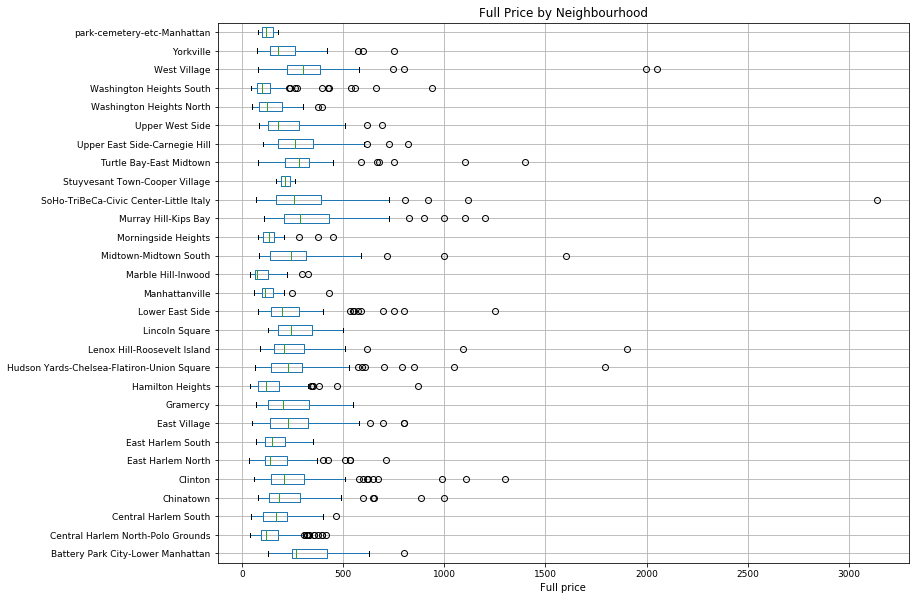

In [39]:
bp = df_airnb[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',vert=False, fontsize=9, figsize=(12,10) )
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

In [40]:
Q1 = df_airnb['full_price'].quantile(0.25)
Q3 = df_airnb['full_price'].quantile(0.75)
IQR = Q3 - Q1

filter = (df_airnb['full_price'] >= Q1 - 1.5 * IQR) & (df_airnb['full_price'] <= Q3 + 1.5 *IQR)
df_airnb_norm = df_airnb.loc[filter]  
df_airnb_norm.shape

(2252, 28)

Text(0.5, 0.98, '')

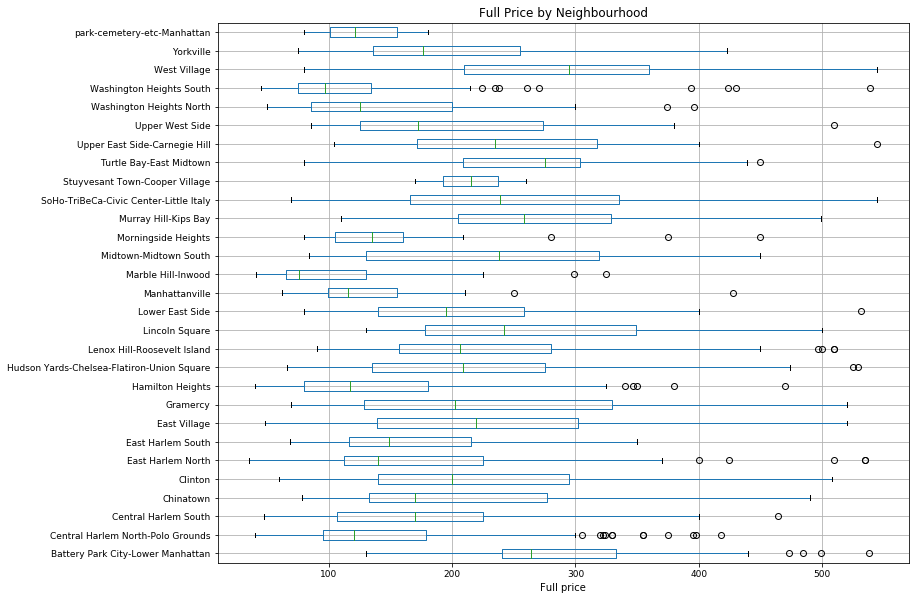

In [41]:
bp = df_airnb_norm[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',vert=False, fontsize=9, figsize=(12,10))
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

In [42]:
neighbourhood_crime_price_merged = df_airnb_norm.copy()
neighbourhood_crime_price_merged = neighbourhood_crime_price_merged.groupby("tab_area", as_index=False).agg({'crimes':'mean', 'price_per_person':'mean', 'accommodates':'count'})
neighbourhood_crime_price_merged.columns=['tab_area', 'mean_crimes', 'mean_price_per_person', 'accommodates']

In [43]:
neighbourhood_crime_price_merged[['tab_area', 'mean_price_per_person', 'accommodates', 'mean_crimes']].sort_values('mean_price_per_person')

,tab_area,mean_price_per_person,accommodates,mean_crimes
15,Marble Hill-Inwood,45.475238,25,54.440000
25,Washington Heights South,46.793172,82,57.682927
24,Washington Heights North,54.738050,53,50.886792
1,Central Harlem North-Polo Grounds,57.038497,132,73.265152
14,Manhattanville,59.746667,25,70.520000
9,Hamilton Heights,60.069404,97,66.206186
28,park-cemetery-etc-Manhattan,61.404762,7,13.428571
5,East Harlem North,62.275497,91,104.824176
6,East Harlem South,64.950000,77,90.051948
2,Central Harlem South,67.000823,94,87.148936


In [44]:
neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged.copy()
neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged3.merge(neighborhoods_geo[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])

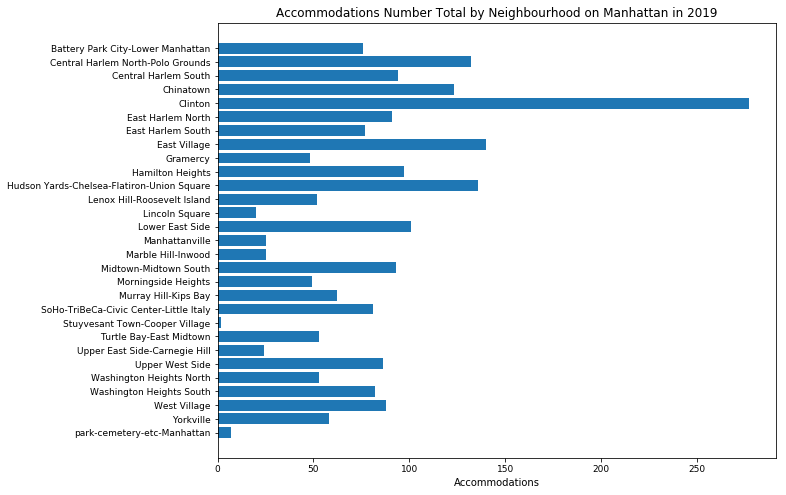

In [45]:
fig, ax = plt.subplots(figsize=(10,8))
x = neighbourhood_crime_price_merged3.index
y = neighbourhood_crime_price_merged3.accommodates
xticks = neighbourhood_crime_price_merged3.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accommodations')
ax.set_title('Accommodations Number Total by Neighbourhood on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

In [46]:
df_manhattan_crime_neighbourhood = df_manhattan_crime.copy()
df_manhattan_crime_neighbourhood = df_manhattan_crime_neighbourhood.groupby("tab_area", as_index=False).agg({'CMPLNT_NUM':'count'})
df_manhattan_crime_neighbourhood.columns=['tab_area', 'crimes_summary']
df_manhattan_crime_neighbourhood.sort_values('crimes_summary')

,tab_area,crimes_summary
20,Stuyvesant Town-Cooper Village,145
28,park-cemetery-etc-Manhattan,1213
11,Lenox Hill-Roosevelt Island,1604
14,Manhattanville,1832
27,Yorkville,1898
15,Marble Hill-Inwood,1900
8,Gramercy,2021
17,Morningside Heights,2321
18,Murray Hill-Kips Bay,2333
7,East Village,2340


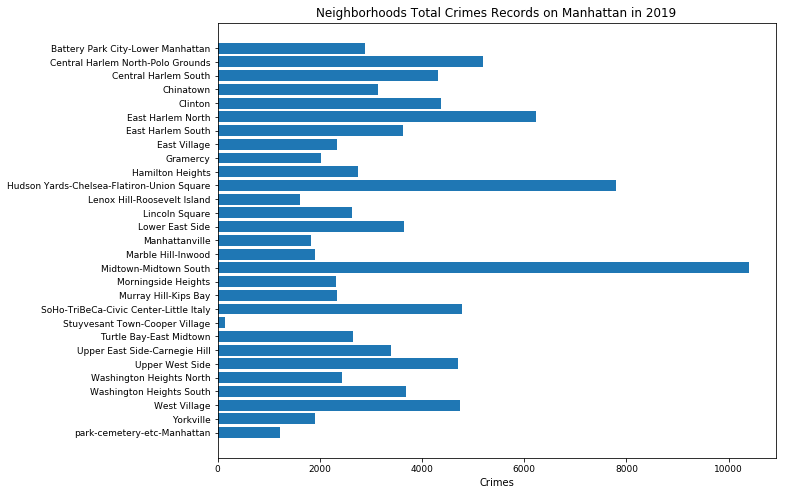

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
x = df_manhattan_crime_neighbourhood.index
y = df_manhattan_crime_neighbourhood.crimes_summary
xticks = df_manhattan_crime_neighbourhood.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read from top to bot
ax.set_xlabel('Crimes')
ax.set_title('Neighborhoods Total Crimes Records on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

In [48]:
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood.copy()
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood2.merge(neighborhoods_geo[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])
df_manhattan_crime_neighbourhood2.head()

,tab_area,crimes_summary,Latitude,Longitude
0,Battery Park City-Lower Manhattan,2883,40.706784,-74.010147
1,Central Harlem North-Polo Grounds,5186,40.819400,-73.941200
2,Central Harlem South,4320,40.802900,-73.952300
3,Chinatown,3137,40.715100,-73.995500
4,Clinton,4364,40.764423,-73.992392


In [49]:
# Neighborhoods prices on Manhattan 2019
nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_price_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_price_map.choropleth(
    geo_data=newyork_data,
    data=neighbourhood_crime_price_merged3,
    columns=['tab_area', 'mean_price_per_person'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, mean_price_per_person, accommodates, mean_crimes  in zip(neighbourhood_crime_price_merged3['Latitude'],
                                                                         neighbourhood_crime_price_merged3['Longitude'], 
                                                                         neighbourhood_crime_price_merged3['tab_area'],
                                                                         round(neighbourhood_crime_price_merged3['mean_price_per_person'],2), 
                                                                         neighbourhood_crime_price_merged3['accommodates'],
                                                                         round(neighbourhood_crime_price_merged3['mean_crimes'],2)):
    label = folium.Popup(str(poi) +  '|| Mean Price per person: $' + str(mean_price_per_person)  +', Accommodates Number: ' + str(accommodates)  + ', Mean Crimes: ' + str(mean_crimes), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_price_map)  
    
nyc_official_neighbourhoods_price_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.


In [51]:
nyc_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=11)
limit = 1000
df_incidents = df_manhattan_crime.sample(limit) 

# instantiate a mark cluster object for the incidents 
incidents = plugins.MarkerCluster().add_to(nyc_crime_map)

# loop dataframe and add data points to the mark cluster
for lat, lng, label, area in zip(df_incidents.Latitude, df_incidents.Longitude, df_incidents.LAW_CAT_CD, df_incidents.tab_area):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# show map
nyc_crime_map

In [52]:
# Neighborhoods Сrimes Summary on Manhattan in 2019
nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_crime_map.choropleth(
    geo_data=newyork_data,
    data=df_manhattan_crime_neighbourhood2,
    columns=['tab_area', 'crimes_summary'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, crimes_summary  in zip(df_manhattan_crime_neighbourhood2['Latitude'],
                                                                         df_manhattan_crime_neighbourhood2['Longitude'], 
                                                                         df_manhattan_crime_neighbourhood2['tab_area'],
                                                                         df_manhattan_crime_neighbourhood2['crimes_summary']
                                                                        ):
    label = folium.Popup(str(poi) +  '|| Crimes Summary: ' + str(crimes_summary), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#8B0000',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_crime_map)  
    

nyc_official_neighbourhoods_crime_map

In [53]:
limit=100
df_airnb_top = df_airnb_norm.sort_values(by=['review_scores_rating',  'full_price','price_per_person',  'crimes'], ascending=[False, True, True, True])[['name', 'tab_area', 'neighbourhood_cleansed','latitude', 'longitude' ,'review_scores_rating',  'property_type', 'room_type', 'accommodates', 'full_price', 'price_per_person', 'crimes', 'listing_url','picture_url','bathrooms', 'bedrooms','square_feet']].head(limit)

In [54]:
df_airnb_top.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,listing_url,picture_url,bathrooms,bedrooms,square_feet
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,40.82749,-73.94461,100.0,Apartment,Private room,2,54.0,27.0,34,https://www.airbnb.com/rooms/34770173,https://a0.muscache.com/im/pictures/aff6d2a3-b6f6-491f-84b3-1e6d2ff35115.jpg?aki_policy=large,1,1,0
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,40.84377,-73.94094,100.0,Apartment,Private room,1,67.0,67.0,32,https://www.airbnb.com/rooms/32589616,https://a0.muscache.com/im/pictures/88aec7e7-eb04-417d-9c42-43a33d4b9426.jpg?aki_policy=large,1,1,0
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,40.84911,-73.93097,100.0,Apartment,Private room,2,74.0,37.0,78,https://www.airbnb.com/rooms/26303788,https://a0.muscache.com/im/pictures/fcc9077f-fab7-4c8f-a62c-1b7340fcaa30.jpg?aki_policy=large,1,1,0
1529,Little Safe Haven,Hamilton Heights,Harlem,40.82494,-73.94280,100.0,Apartment,Private room,1,80.0,80.0,43,https://www.airbnb.com/rooms/29205817,https://a0.muscache.com/im/pictures/97143bde-79c7-4112-8bfa-fb219529c4e6.jpg?aki_policy=large,1,1,0
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,40.76026,-73.96590,100.0,Apartment,Private room,1,80.0,80.0,64,https://www.airbnb.com/rooms/13246804,https://a0.muscache.com/im/pictures/b4722160-be37-4701-a2e5-36cfe38f7a27.jpg?aki_policy=large,1,2,0


In [55]:
CLIENT_ID = '2ISEV1BQELTEGUC240PXI1ISJJQLEOOBDUGZMDOPOVSSGAO0' # Foursquare ID
CLIENT_SECRET = 'QO0FTBIJLB3HJYE4IWYPNJU05ZEBRIAASLPL5II3PMF0JPUN' #Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50
RADIUS = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2ISEV1BQELTEGUC240PXI1ISJJQLEOOBDUGZMDOPOVSSGAO0
CLIENT_SECRET:QO0FTBIJLB3HJYE4IWYPNJU05ZEBRIAASLPL5II3PMF0JPUN


In [56]:
def getAccomodatesNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list=[]
    nearby_venues = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        try:
            response = requests.get(url)
            if response.status_code == 200: 
                results = response.json()["response"]['groups'][0]['items']
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['name', 
                                         'latitude', 
                                         'longitude', 
                                         'Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']
            else:
                print ("Exception during call URL={} , Code={}, Text={}".format(url, response.status_code, response.text))
        except Exception as e:
            print ("Exception: {}".format(e))
            raise e
    
    return(nearby_venues)

In [57]:
df_airnb_top_venues = getAccomodatesNearbyVenues(names=df_airnb_top['name'],
                                   latitudes=df_airnb_top['latitude'],
                                   longitudes=df_airnb_top['longitude'],
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )

Private Bedroom in Cozy Hamilton Heights Apartment
Mr. B - Room Apartment in NYC
Cozy sanctuary/Big master bedroom/NYC/The Heights
Little Safe Haven
One cozy private BR close to the mecca of shopping
Spacious and Modern Hideout | Close to Everything
Master Suite near NYP/CUMC and 2 blks from Subway
Gorgeous Manhattan Hideout | Close to Everything
Old School New York
157-C
Large UWS Private Bedroom with Outdoor Space
Park-lovers Paradise in Central Manhattan
A neat bedroom in a cozy 3-bedroom apartment
Massive sun filled room on Central Park West.
airy, earthy room in artistic apt
U W S Sunny Queen size bedroom near Columbia UNI*
Luxury Street View Room 2 blocks from Times Square
Huge modern room in a cozy sunny home
Beautiful, sunlit private room in Spanish Harlem
Exception during call URL=https://api.foursquare.com/v2/venues/explore?&client_id=2ISEV1BQELTEGUC240PXI1ISJJQLEOOBDUGZMDOPOVSSGAO0&client_secret=QO0FTBIJLB3HJYE4IWYPNJU05ZEBRIAASLPL5II3PMF0JPUN&v=20180605&ll=40.792,-73.945219

In [58]:
df_airnb_top_venues.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Branson Got Juice!,40.825525,-73.943681,Juice Bar
1,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Harlem Public,40.828803,-73.948685,Bar
2,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Buddha Taco Bar,40.829007,-73.948089,Bar
3,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Monkey Cup,40.825694,-73.947234,Coffee Shop
4,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,The Honeywell,40.828549,-73.948739,Speakeasy


In [59]:
df_airnb_top_venues.shape

(4950, 7)

In [60]:
fine_art_cat = ['Art','Arts','Museum', 'Library','Exhibit','Gallery']
eat_place_cat = ['Restaurant','Steakhouse']
shopping_cat = ['Shopping Mall','Market','Boutique']
outdoor_cat = ['Sculpture Garden','Scenic Lookout','Roof Deck','Outdoor Sculpture','Monument / Landmark',
               'Memorial Site','Lighthouse','Historic Site','Harbor / Marina','Fountain','Event Space','Bridge',
               'Waterfront','Church','Building','Garden','Historic Site','Lake','Park',
               'Pier','Rest Area','River','Synagogue','Field']
entertainment_cat = ['Nightclub','Circus','Club', 'Stadium', 'Karaoke Bar', 'Pub','Theater','Opera', 'Concert', 'Zoo']

#Combine all categories' values in one
tourists_categories = fine_art_cat + eat_place_cat + shopping_cat + outdoor_cat +entertainment_cat

In [61]:
# Get Venues from Custom Categories
def check(category):
    if any(word in category for word in tourists_categories):
        return True
    return False

In [62]:
# Identify Venue's Category
def change_categoty(name):
    if any(word in name for word in entertainment_cat):
        return 'Entertainment'
    if any(word in name for word in fine_art_cat):
        return 'Fine Art'
    if any(word in name for word in eat_place_cat):
        return 'Food Place'
    if any(word in name for word in shopping_cat):        
        return 'Shopping'
    if any(word in name for word in outdoor_cat):            
        return 'Sightseeing'
    if any(word in name for word in tansportation_cat):            
        return 'Transportation'

In [63]:
# Identify Top Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:num_top_venues] 

def return_most_common_venues_stats(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:num_top_venues]

In [64]:
df_airnb_top_venues_f = df_airnb_top_venues[df_airnb_top_venues['Venue Category'].apply(lambda x: check(x))].copy()
df_airnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Wat’s On Your Plate,40.825632,-73.948494,Caribbean Restaurant
6,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Barepas,40.827717,-73.946173,Arepa Restaurant
7,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Bono Trattoria,40.830180,-73.947420,Italian Restaurant
8,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Convent Garden,40.828560,-73.942531,Garden
12,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Riverside Drive Running Path,40.827738,-73.942124,Scenic Lookout


In [65]:
df_airnb_top_venues_f.rename(columns = {'Venue Category':'Venue Type'}, inplace = True)

In [66]:
df_airnb_top_venues_f['Venue Category'] = df_airnb_top_venues_f['Venue Type'].apply(lambda x: change_categoty(x))
df_airnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Type,Venue Category
5,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Wat’s On Your Plate,40.825632,-73.948494,Caribbean Restaurant,Food Place
6,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Barepas,40.827717,-73.946173,Arepa Restaurant,Food Place
7,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Bono Trattoria,40.830180,-73.947420,Italian Restaurant,Food Place
8,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Convent Garden,40.828560,-73.942531,Garden,Sightseeing
12,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Riverside Drive Running Path,40.827738,-73.942124,Scenic Lookout,Sightseeing


In [67]:
# one hot encoding
airnb_onehot = pd.get_dummies(df_airnb_top_venues_f[['Venue Category']], prefix="", prefix_sep="")

# add name column to dataframe
airnb_onehot['name'] = df_airnb_top_venues_f['name'] 

# move name column to first column
fixed_columns = [airnb_onehot.columns[-1]] + list(airnb_onehot.columns[:-1])
airnb_onehot = airnb_onehot[fixed_columns]

In [68]:
airnb_grouped = (np.round(airnb_onehot.groupby('name').mean(),2)).reset_index()
airnb_grouped.head()

,name,Entertainment,Fine Art,Food Place,Shopping,Sightseeing
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",0.36,0.00,0.64,0.00,0.00
1,157-C,0.04,0.12,0.58,0.00,0.25
2,A neat bedroom in a cozy 3-bedroom apartment,0.03,0.03,0.45,0.03,0.45
3,Art filled peaceful paradise EV Union Square,0.17,0.00,0.67,0.08,0.08
4,Artsy Parisian Apt in Greenwich Village,0.25,0.00,0.65,0.00,0.10


In [69]:
# Find top 3 Venues Category
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns by number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create new dataframe
airnb_venues_sorted = pd.DataFrame(columns=columns)
airnb_venues_sorted['name'] = airnb_grouped['name']

for ind in np.arange(airnb_grouped.shape[0]):
    strings_stats = np.around(return_most_common_venues_stats(airnb_grouped.iloc[ind, :], num_top_venues),2) 
    strings_category = return_most_common_venues(airnb_grouped.iloc[ind, :], num_top_venues)
    airnb_venues_sorted.iloc[ind, 1:] = np.concatenate([strings_category,strings_stats ])

airnb_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


In [70]:
# set cluster number
kclusters = 3

airnb_grouped_clustering = airnb_grouped.drop('name', 1)

# run k-means 
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airnb_grouped_clustering)

# check cluster labels made for each row 
kmeans.labels_[0:10]

array([2, 1, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [71]:
# add clustering labels
airnb_venues_clustered = airnb_venues_sorted.copy()
airnb_venues_clustered.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


In [72]:
airnb_venues_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
airnb_venues_clustered.head()

,Cluster Labels,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,2,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,1,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,1,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,0,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,0,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


In [73]:
airnb_merged = df_airnb_top.copy()
#  add lat/long 
airnb_merged  = airnb_merged.join(airnb_venues_clustered.set_index('name'), on='name')
airnb_merged = airnb_merged.dropna()
airnb_merged.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,listing_url,picture_url,bathrooms,bedrooms,square_feet,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,40.82749,-73.94461,100.0,Apartment,Private room,2,54.0,27.0,34,https://www.airbnb.com/rooms/34770173,https://a0.muscache.com/im/pictures/aff6d2a3-b6f6-491f-84b3-1e6d2ff35115.jpg?aki_policy=large,1,1,0,1.0,Food Place,Sightseeing,Fine Art,0.67,0.28,0.06
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,40.84377,-73.94094,100.0,Apartment,Private room,1,67.0,67.0,32,https://www.airbnb.com/rooms/32589616,https://a0.muscache.com/im/pictures/88aec7e7-eb04-417d-9c42-43a33d4b9426.jpg?aki_policy=large,1,1,0,0.0,Food Place,Sightseeing,Shopping,0.75,0.2,0.05
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,40.84911,-73.93097,100.0,Apartment,Private room,2,74.0,37.0,78,https://www.airbnb.com/rooms/26303788,https://a0.muscache.com/im/pictures/fcc9077f-fab7-4c8f-a62c-1b7340fcaa30.jpg?aki_policy=large,1,1,0,0.0,Food Place,Sightseeing,Shopping,0.78,0.19,0.04
1529,Little Safe Haven,Hamilton Heights,Harlem,40.82494,-73.94280,100.0,Apartment,Private room,1,80.0,80.0,43,https://www.airbnb.com/rooms/29205817,https://a0.muscache.com/im/pictures/97143bde-79c7-4112-8bfa-fb219529c4e6.jpg?aki_policy=large,1,1,0,0.0,Food Place,Sightseeing,Fine Art,0.74,0.16,0.11
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,40.76026,-73.96590,100.0,Apartment,Private room,1,80.0,80.0,64,https://www.airbnb.com/rooms/13246804,https://a0.muscache.com/im/pictures/b4722160-be37-4701-a2e5-36cfe38f7a27.jpg?aki_policy=large,1,2,0,0.0,Food Place,Entertainment,Sightseeing,0.69,0.12,0.06


In [74]:
df_airnb_norm.groupby(['tab_area','neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('NYC Tab Area')

,NYC Tab Area,Airbnb Neighbourhood,Count
0,Battery Park City-Lower Manhattan,Battery Park City,1
1,Battery Park City-Lower Manhattan,Financial District,75
2,Central Harlem North-Polo Grounds,East Harlem,15
3,Central Harlem North-Polo Grounds,Harlem,117
4,Central Harlem South,Harlem,94
5,Chinatown,Chinatown,48
6,Chinatown,Civic Center,1
7,Chinatown,Lower East Side,60
8,Chinatown,Two Bridges,14
9,Clinton,Hell's Kitchen,277


In [75]:
df_airnb_norm.groupby(['tab_area']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area'}).sort_values('Count', ascending = False)

,NYC Tab Area,Count
4,Clinton,277
7,East Village,140
10,Hudson Yards-Chelsea-Flatiron-Union Square,136
1,Central Harlem North-Polo Grounds,132
3,Chinatown,123
13,Lower East Side,101
9,Hamilton Heights,97
2,Central Harlem South,94
16,Midtown-Midtown South,93
5,East Harlem North,91


In [76]:
df_airnb_norm.groupby(['neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Count', ascending = False)

,Airbnb Neighbourhood,Count
10,Harlem,336
11,Hell's Kitchen,335
5,East Village,197
4,East Harlem,183
29,Upper West Side,136
30,Washington Heights,128
28,Upper East Side,127
17,Midtown,106
15,Lower East Side,100
1,Chelsea,93


In [78]:
cluster0 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 0, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster0.describe()

,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0
mean,100.0,2.181818,222.109091,106.347879,68.036364,1.018182,1.036364,0.0
std,0.0,0.883824,114.362107,46.475378,59.104103,0.234987,0.428764,0.0
min,100.0,1.000000,67.000000,37.000000,3.000000,0.000000,0.000000,0.0
25%,100.0,2.000000,134.500000,69.750000,38.500000,1.000000,1.000000,0.0
50%,100.0,2.000000,191.000000,97.500000,52.000000,1.000000,1.000000,0.0
75%,100.0,2.500000,290.000000,137.250000,78.000000,1.000000,1.000000,0.0
max,100.0,5.000000,519.000000,259.500000,385.000000,2.000000,2.000000,0.0


In [79]:
cluster0

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,100.0,Apartment,Private room,1,67.0,67.000000,32,1,1,0.0,Food Place,Sightseeing,Shopping,0.75,0.2,0.05
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,100.0,Apartment,Private room,2,74.0,37.000000,78,1,1,0.0,Food Place,Sightseeing,Shopping,0.78,0.19,0.04
1529,Little Safe Haven,Hamilton Heights,Harlem,100.0,Apartment,Private room,1,80.0,80.000000,43,1,1,0.0,Food Place,Sightseeing,Fine Art,0.74,0.16,0.11
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,100.0,Apartment,Private room,1,80.0,80.000000,64,1,2,0.0,Food Place,Entertainment,Sightseeing,0.69,0.12,0.06
1694,Master Suite near NYP/CUMC and 2 blks from Subway,Washington Heights South,Washington Heights,100.0,Apartment,Private room,2,85.0,42.500000,64,0,1,0.0,Food Place,Sightseeing,Shopping,0.8,0.15,0.05
2216,Large UWS Private Bedroom with Outdoor Space,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,90.0,45.000000,32,1,1,0.0,Food Place,Sightseeing,Entertainment,0.81,0.11,0.07
2118,Huge modern room in a cozy sunny home,Central Harlem South,Harlem,100.0,Apartment,Private room,2,110.0,55.000000,69,2,1,0.0,Food Place,Entertainment,Fine Art,0.62,0.17,0.12
2240,Spacious & bright apartment in the heart of Harlem,Central Harlem North-Polo Grounds,Harlem,100.0,Apartment,Private room,3,120.0,40.000000,232,1,1,0.0,Food Place,Sightseeing,Fine Art,0.62,0.12,0.12
2119,Contemporary bedroom in a cozy sunny home,Central Harlem South,Harlem,100.0,Apartment,Private room,2,120.0,60.000000,33,2,1,0.0,Food Place,Entertainment,Shopping,0.59,0.18,0.09
2100,Bright Bohemian Gem in the Lower East Side,Chinatown,Chinatown,100.0,Apartment,Entire home/apt,2,120.0,60.000000,56,1,1,0.0,Food Place,Entertainment,Sightseeing,0.77,0.12,0.04


In [80]:
sorted(cluster0.tab_area.unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lower East Side',
 'Marble Hill-Inwood',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville']

In [81]:
sorted(cluster0.neighbourhood_cleansed.unique())

['Chelsea',
 'Chinatown',
 'East Harlem',
 'East Village',
 'Financial District',
 'Gramercy',
 'Greenwich Village',
 'Harlem',
 "Hell's Kitchen",
 'Inwood',
 'Lower East Side',
 'Midtown',
 'Murray Hill',
 'Nolita',
 'SoHo',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights',
 'West Village']

In [82]:
cluster1 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 1, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster1.describe()

,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,99.931034,3.103448,202.482759,70.043103,59.586207,1.241379,1.103448,1.0
std,0.257881,1.952010,124.588357,39.698427,37.750608,0.510964,0.488791,0.0
min,99.000000,1.000000,54.000000,27.000000,4.000000,1.000000,0.000000,1.0
25%,100.000000,2.000000,90.000000,47.000000,34.000000,1.000000,1.000000,1.0
50%,100.000000,2.000000,180.000000,62.000000,54.000000,1.000000,1.000000,1.0
75%,100.000000,4.000000,270.000000,70.000000,82.000000,1.000000,1.000000,1.0
max,100.000000,10.000000,470.000000,225.000000,154.000000,3.000000,3.000000,1.0


In [83]:
cluster1

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,54.0,27.000000,34,1,1,1.0,Food Place,Sightseeing,Fine Art,0.67,0.28,0.06
2130,Spacious and Modern Hideout | Close to Everything,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,85.0,42.500000,47,1,1,1.0,Food Place,Sightseeing,Fine Art,0.57,0.24,0.14
2129,Gorgeous Manhattan Hideout | Close to Everything,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,85.0,42.500000,66,1,1,1.0,Food Place,Sightseeing,Fine Art,0.62,0.19,0.14
1219,Old School New York,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,87.0,43.500000,4,1,1,1.0,Food Place,Sightseeing,Entertainment,0.67,0.28,0.06
2339,157-C,Washington Heights South,Washington Heights,100.0,Apartment,Private room,2,87.0,43.500000,14,1,1,1.0,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
1214,Park-lovers Paradise in Central Manhattan,Central Harlem South,Harlem,100.0,Apartment,Private room,2,90.0,45.000000,76,2,1,1.0,Food Place,Sightseeing,Shopping,0.59,0.26,0.07
1627,A neat bedroom in a cozy 3-bedroom apartment,Lenox Hill-Roosevelt Island,Roosevelt Island,100.0,Apartment,Private room,1,90.0,90.000000,23,1,1,1.0,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
2232,Massive sun filled room on Central Park West.,Morningside Heights,Upper West Side,100.0,Apartment,Private room,2,95.0,47.500000,32,1,1,1.0,Food Place,Sightseeing,Shopping,0.59,0.37,0.04
384,"airy, earthy room in artistic apt",Washington Heights North,Washington Heights,100.0,Apartment,Private room,1,100.0,100.000000,82,1,1,1.0,Food Place,Sightseeing,Shopping,0.73,0.23,0.05
1804,U W S Sunny Queen size bedroom near Columbia UNI*,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,110.0,55.000000,36,2,1,1.0,Food Place,Sightseeing,Shopping,0.61,0.35,0.04


In [84]:
sorted(cluster1.tab_area.unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem South',
 'East Harlem North',
 'East Harlem South',
 'Hamilton Heights',
 'Lenox Hill-Roosevelt Island',
 'Morningside Heights',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village']

In [85]:
sorted(cluster1.neighbourhood_cleansed.unique())

['East Harlem',
 'Financial District',
 'Harlem',
 'Inwood',
 'Morningside Heights',
 'Roosevelt Island',
 'Upper West Side',
 'Washington Heights',
 'West Village']

In [86]:
cluster2 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 2, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster2.describe()

,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,15.0,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.0
mean,100.0,2.666667,273.733333,111.403333,102.000000,1.0,0.866667,2.0
std,0.0,1.175139,96.230725,40.353361,64.378346,0.0,0.516398,0.0
min,100.0,1.000000,110.000000,55.000000,23.000000,1.0,0.000000,2.0
25%,100.0,2.000000,210.000000,79.650000,61.000000,1.0,1.000000,2.0
50%,100.0,2.000000,275.000000,105.000000,74.000000,1.0,1.000000,2.0
75%,100.0,4.000000,329.500000,137.500000,130.500000,1.0,1.000000,2.0
max,100.0,5.000000,420.000000,200.000000,257.000000,1.0,2.000000,2.0


In [87]:
cluster2

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2352,Luxury Street View Room 2 blocks from Times Square,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,110.0,55.00,64,1,1,2.0,Entertainment,Food Place,Fine Art,0.58,0.38,0.04
2152,Studio (200 sq ft.) near Times Square!,Clinton,Hell's Kitchen,100.0,Apartment,Entire home/apt,1,154.0,154.00,89,1,0,2.0,Entertainment,Food Place,Fine Art,0.56,0.37,0.07
997,Experience the heart of Hell's Kitchen.,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,155.0,77.50,41,1,1,2.0,Food Place,Entertainment,Fine Art,0.63,0.33,0.04
675,"Superhost Chelsea Large, Private, Quiet bedroom",Hudson Yards-Chelsea-Flatiron-Union Square,Chelsea,100.0,Apartment,Private room,2,175.0,87.50,59,1,1,2.0,Fine Art,Food Place,Sightseeing,0.38,0.29,0.14
1059,"Midtown near Times Square, Broadway & Central Park",Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,245.0,122.50,56,1,1,2.0,Food Place,Entertainment,Sightseeing,0.61,0.39,0
904,PRIVATE BATH next to Central Park!,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,254.0,127.00,23,1,1,2.0,Food Place,Entertainment,Fine Art,0.63,0.32,0.05
1448,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Clinton,Hell's Kitchen,100.0,Condominium,Private room,2,270.0,135.00,114,1,1,2.0,Food Place,Entertainment,Sightseeing,0.64,0.36,0
1568,DESIGNER 1 BEDROOM APARTMENT,Clinton,Hell's Kitchen,100.0,Apartment,Entire home/apt,4,275.0,68.75,147,1,1,2.0,Entertainment,Food Place,Fine Art,0.56,0.36,0.08
1254,High End Hilton Club in midtown Manhattan,Midtown-Midtown South,Midtown,100.0,Serviced apartment,Entire home/apt,2,280.0,140.00,63,1,0,2.0,Food Place,Entertainment,Fine Art,0.59,0.23,0.14
1985,GORGEOUS WEST CHELSEA TWO BEDROOM with roof deck!,Hudson Yards-Chelsea-Flatiron-Union Square,Chelsea,100.0,Apartment,Entire home/apt,4,300.0,75.00,165,1,2,2.0,Fine Art,Food Place,Entertainment,0.46,0.23,0.19


In [88]:
sorted(cluster2.tab_area.unique())

['Clinton',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Midtown-Midtown South']

In [89]:
sorted(cluster2.neighbourhood_cleansed.unique())

['Chelsea', "Hell's Kitchen", 'Midtown']